# Taller 5

## Objetivos

## Actividades a realizar

## Python

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
driver = gdal.GetDriverByName('GTiff')
file = gdal.Open(r'G:\My Drive\CATEDRA\MACHINE LEARNING/datos/raster/slope_rad')
pendiente = file.GetRasterBand(1)
pendiente = pendiente.ReadAsArray()
pendiente=np.where(pendiente==-3.4028234663852886e+38,np.nan,pendiente)
pendiente=pendiente*180/np.pi
pendiente_vector=pendiente.ravel()
pendiente_vector2=np.nan_to_num(pendiente_vector)
pendiente_vector_MenM=pendiente_vector[~np.isnan(pendiente_vector)] # para eliminar  del vector los datos inf

raster = gdal.Open(r'G:\My Drive\CATEDRA\MACHINE LEARNING/datos/raster/curvatura')
curvatura=raster.GetRasterBand(1)
curvatura=curvatura.ReadAsArray()
curvatura=np.where(curvatura==-3.4028234663852886e+38,np.nan,curvatura)
curvatura_vector=curvatura.ravel()
curvatura_vector2=np.nan_to_num(curvatura_vector)
curvatura_vector_MenM=curvatura_vector[~np.isnan(curvatura_vector)]

raster = gdal.Open(r'G:\My Drive\CATEDRA\MACHINE LEARNING/datos/raster/aspecto')
aspecto=raster.GetRasterBand(1)
aspecto=aspecto.ReadAsArray()
aspecto=np.where(aspecto==-3.4028234663852886e+38,np.nan,aspecto)
aspecto_vector=aspecto.ravel()
aspecto_vector2=np.nan_to_num(aspecto_vector)
aspecto_vector_MenM=aspecto_vector[~np.isnan(aspecto_vector)]

raster = gdal.Open(r'G:\My Drive\CATEDRA\MACHINE LEARNING/datos/raster/flowacum_m2')
flujo=raster.GetRasterBand(1)
flujo=flujo.ReadAsArray()
flujo=np.where(flujo==-3.4028234663852886e+38,np.nan,flujo)
flujo_vector=flujo.ravel()
flujo_vector2=np.nan_to_num(flujo_vector)
flujo_vector_MenM=flujo_vector[~np.isnan(flujo_vector)]

raster = gdal.Open(r'G:\My Drive\CATEDRA\MACHINE LEARNING/datos/raster/inventario.tif')
inventario=raster.GetRasterBand(1)
inventario=inventario.ReadAsArray()
msk=np.where(pendiente>=0,1,np.nan)
inventario=msk*inventario
inventario=np.where(inventario==1,0,inventario)
inventario=np.where(inventario==2,1,inventario)
inventario_vector=inventario.ravel()
inventario_vector_MenM=inventario_vector[~np.isnan(inventario_vector)]

In [3]:
#Dataframe con las variables filtradas 
d={'inventario':inventario_vector_MenM,'pendiente':pendiente_vector_MenM,'flujo_acum':flujo_vector_MenM,'aspecto':aspecto_vector_MenM,
   'curvatura':curvatura_vector_MenM}
x = pd.DataFrame(d)
y=x['inventario']
x.drop('inventario', axis=1, inplace=True)
print('vectores de x',list(x.columns))
columns=x.columns

#Dataframe de las variables de todo el mapa
f={'pendiente':pendiente_vector2,'flujo_acum':flujo_vector2,'aspecto':aspecto_vector2, 'curvatura':curvatura_vector2}
x_map=pd.DataFrame(f)
print('vectores de x-map',list(x_map.columns))

vectores de x ['pendiente', 'flujo_acum', 'aspecto', 'curvatura']
vectores de x-map ['pendiente', 'flujo_acum', 'aspecto', 'curvatura']


Inicialmente siempre se importa la funcion del método de la librearia de Sklearn. La implementación de todos los métodos es igual, inicialmente se debe crear la funcion con las características del método a implementar, posteriormente se entrena el modelo con los datos utilizando la función fit, y finalmente se utiliza la función predict para obtener la prediccion del modelo de acuerdo con el entrenamiento realizado. Al final de cada método se utiliza el dataframe de toda la cuenca para obtener el mapa del indice de Susceptibildiad (IS).

## Redes Neuronales. 
El primer método a utilizar es el de Multi Layer Perceptron. en este caso se recomienda estandarizar las variables, utilizando la función scaler. Y para generar el modelo se utilizarán dos capas escondidas, una de 5 neuronas y otra de 2 neuronas, con un número de 500 interacciones. Existen muchos mas parametros del modelo que se pueden revisar en la pagina web de la librería.

In [4]:
from sklearn.neural_network import MLPClassifier

#Estandarizar las variables
scaler = StandardScaler()

# Fit only to the training data
scaler.fit(x)
#StandardScaler(copy=True, with_mean=True, with_std=True)

# Now apply the transformations to the data:
x = scaler.transform(x)

#Implementar el modelo de Redes neuronales denominado Multilayer Perceptron, en este caso dos capas escondidas de 5 y 2 neuronas
mlp = MLPClassifier(hidden_layer_sizes=(5,2),max_iter=500)
mlp.fit(x,y)
predictions = mlp.predict(x)

#prediccion de todo el mapa
IS=mlp.predict(x_map)

## Decision Tree 
En el método Arbol de Decisión se puede visualizar el arbol generado.

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

# Make a decision tree and train
tree = DecisionTreeClassifier(random_state=8)

# Train the model on training data
tree.fit(x, y)

print(f'El Arbol de decisión tiene {tree.tree_.node_count} nodos con una profundidad máxima de {tree.tree_.max_depth}.')

# Para exportar como imagen el arbol de decision, priemro Export as dot
export_graphviz(tree, 'tree.dot', rounded = True, feature_names = columns, class_names = ['0', '1'], filled = True)
# Use dot file to create a graph
#import pydot
#(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
#graph.write_png('G:\My Drive/tree.png')

#Obtener las predicciones y probabilidad de las predicciones para lso datos de entrenamiento y los datos de validación
train_probs=tree.predict_proba(x)[:,1]
train_predictions = tree.predict(x)

#prediccion de todo el mapa
IS=tree.predict(x_map)
IS_Pro=tree.predict_proba(x_map)[:,1]

El Arbol de decisión tiene 8405 nodos con una profundidad máxima de 47.


## Random Forest. 
Adicionalmente para el método de Random Forest se puede observar un arbol de todo el Bosque y limitar la profundidad del Bosque a generar. El método tambien permite cuantificar la importancia de cada variable.

In [11]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate model 
rf = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Train the model on training data
rf.fit(x, y);

# Use the forest's predict method on the test data
predictions = rf.predict(x)

#Para predecir todo el mapa
IS=rf.predict(x_map)

# Pull out one tree from the forest
tree = rf.estimators_[5]

# Export as dot
export_graphviz(tree, 'tree.dot', rounded = True, feature_names = columns, class_names = ['0', '1'], filled = True)
# Use dot file to create a graph
#import pydot
#(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
#graph.write_png('G:\My Drive/tree.png')

# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(x, y)

# Extraer un arbol del bosque
tree_small = rf_small.estimators_[5]

# Save the tree as a png image
#export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = columns, rounded = True, precision = 1)
#(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
#graph.write_png('G:\My Drive/small_tree.png');

#Para saber la importancia de las variables utilizadas
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]


Variable: pendiente            Importance: 0.33
Variable: aspecto              Importance: 0.3
Variable: curvatura            Importance: 0.3
Variable: flujo_acum           Importance: 0.06


[None, None, None, None]

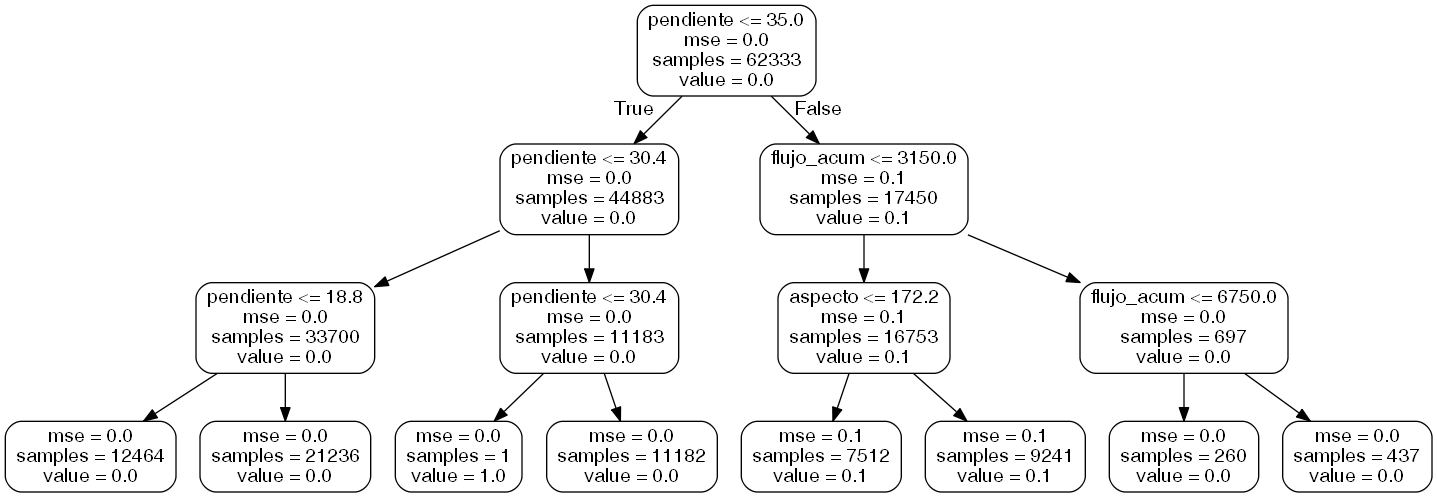

## Análisis Discriminante. 

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

LDA = LinearDiscriminantAnalysis(n_components=2)
data_projected = LDA.fit_transform(x,y)
print(data_projected.shape)

#predicting the test set results
y_pred = LDA.predict(x)

#Para predecir todo el mapa
IS=LDA.predict(x_map)

ValueError: n_components cannot be larger than min(n_features, n_classes - 1).

## Support Vector Machine.

In [ ]:
from sklearn.svm import SVC # "Support vector classifier"

model = SVC(kernel='linear', C=1E10)
model.fit(x, y)

#Para obtener los puntos que separan conocidos como Support vectors
model.support_vectors_

#Para predecir con los datos de test
y_pred=model.predict(x)

#Para predecir todo el mapa
IS=model.predict(x)

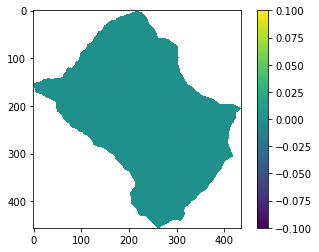

In [10]:
#Para exporta el mapa de IS utilizando gdal

#mascara para crear el mapa de la cuenca
file = gdal.Open(r'G:\My Drive\CATEDRA\MACHINE LEARNING/datos/raster/slope_rad')
pendiente = file.GetRasterBand(1)
pendiente = pendiente.ReadAsArray()

IS_2=IS_Pro.reshape(pendiente.shape)
IS_3=np.where(pendiente==-3.4028234663852886e+38,np.nan,IS_2)
plt.imshow(IS_3)
plt.colorbar()

# create new file
file2 = driver.Create( r'G:\My Drive\CATEDRA\MACHINE LEARNING/datos/raster/IS_LDA.tif', file.RasterXSize , file.RasterYSize , 1)
file2.GetRasterBand(1).WriteArray(IS_3)

# spatial ref system
proj = file.GetProjection()
georef = file.GetGeoTransform()
file2.SetProjection(proj)
file2.SetGeoTransform(georef)
file2.GetRasterBand(1).SetNoDataValue(-9999)
file2.FlushCache()